# Dessin d'un *volcano plot*

Le *volcano plot* est une représentation graphique courante lorsqu'on analyse des données omiques.

## Modules Python utilisés

Chargeons d'abord les modules Python nécessaires pour cette analyse

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Jeu de données

<div class="alert alert-info">
    
Les données expérimentales utilisées dans ce notebook proviennent d'expériences de spectrométrie de masse. Elles ont été adaptées de l'article :  
*Quantitative Proteomics in Friedreich's Ataxia B-lymphocytes: A Valuable Approach to Decipher the Biochemical Events Responsible for Pathogenesis*  
Télot *et al*, Biochimica et Biophysica Acta (BBA) - Molecular Basis of Disease, 2018.  
DOI: [10.1016/j.bbadis.2018.01.010](https://doi.org/10.1016/j.bbadis.2018.01.010)
    
</div>

In [3]:
exp_df = pd.read_csv("data_friedreich_ataxia.csv", index_col="accession")

On affiche les dimensions et les premières lignes du jeu de données :

In [4]:
print("Dimensions : {} x {}".format(*exp_df.shape))
exp_df.head()

Dimensions : 2694 x 3


,abundance WT,abundance FRDA,p-value
accession,,,
P01876,4.650254e+05,5.488983e+06,0.000095
P28289,3.171518e+04,9.224471e+04,0.000013
P01871,1.596695e+06,5.501002e+04,0.000808
Q9H0E2,6.336450e+04,1.354001e+05,0.000021
P01857,8.030646e+05,1.104635e+05,0.000196


Ce jeu de données contient, pour 2694 protéines :

- l'abondance (moyenne et normalisée) mesurée par spectrométrie de masse provenant de cellules saines (condition WT) ;
- l'abondance (moyenne et normalisée) mesurée par spectrométrie de masse provenant de cellules de patients (condition FRDA) ;
- les valeurs de p-value associées.

## Calcul du *fold change*

On définit le *fold change* comme le rapport entre l'abondance de la condition FRDA sur l'abondance de la condition WT.

In [5]:
exp_df["fold change"] = exp_df["abundance FRDA"] / exp_df["abundance WT"]
exp_df.head()

,abundance WT,abundance FRDA,p-value,fold change
accession,,,,
P01876,4.650254e+05,5.488983e+06,0.000095,11.803619
P28289,3.171518e+04,9.224471e+04,0.000013,2.908535
P01871,1.596695e+06,5.501002e+04,0.000808,0.034452
Q9H0E2,6.336450e+04,1.354001e+05,0.000021,2.136844
P01857,8.030646e+05,1.104635e+05,0.000196,0.137552


## Première représentation

En première intention, une représentation de la p-value en fonction du *fold change* pourrait être la suivante :

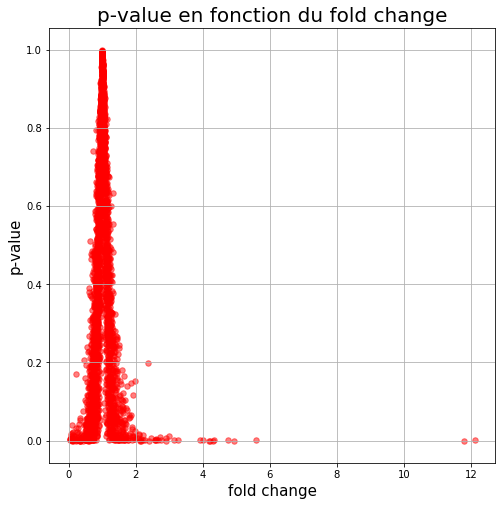

In [6]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1)
ax.set_title("p-value en fonction du fold change", fontsize = 20)
ax.set_xlabel("fold change", fontsize = 15)
ax.set_ylabel("p-value", fontsize = 15)
ax.scatter(exp_df["fold change"], exp_df["p-value"],
           s=30, alpha=0.5, c="red")
ax.grid()

Cette représentation pose plusieurs problèmes :

L'axe des abscisses est deséquilibré. Si l'abondance FRDA est supérieure à celle de l'abondance WT, alors le *fold change* prend des valeurs entre 1 et $+\infty$. Par contre, si l'abondance WT est supérieure à l'abondance FRDA, alors le *fold change* prend des valeurs entre 0 et 1. Les tailles des deux intervalles ($[1, +\infty$ d'une part et $]0, 1]$ d'autre part) ne sont pas comparables. Utiliser le $\log_2(\text{fold change})$ équilibre les valeurs autour de 0 (entre $-\infty$ et $+\infty$). Par ailleurs, la fonction $\log_2$ condense l'échelle de valeurs possibles. Une valeur de 1 pour le $\log_2$ correspond à un *fold change* de 2, une valeur de 2 pour le $\log_2$ correspond à un *fold change* de 4...

Sur l'axe des ordonnées, les valeur de p-values a priori les plus *intéressantes* (< à 0.05) se trouvent tassées près de 0. Avec $-\log_{10}(\text{p-value})$, les valeurs les plus intéressantes se trouvent en haut de l'axe (vers $+\infty$). La fonction $\log_{10}$ condense également les valeurs. Chaque unité de $\log_{10}$ correspond à un ordre de grandeur ($\times 10$).

## Représentation *volcano plot*

Nous utilisons les méthodes *NumPy* `np.log2()` et `np.log10()` pour transformer les valeurs de *fold change* et de p-value.

In [7]:
exp_df["log fold change"] = np.log2(exp_df["fold change"])
exp_df["log p-value"] = -np.log10(exp_df["p-value"])

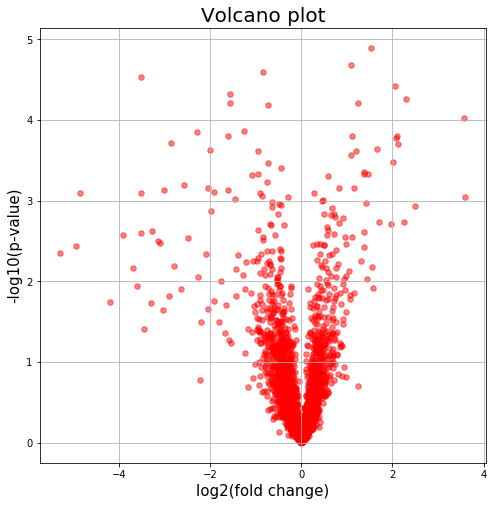

In [8]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel("log2(fold change)", fontsize = 15)
ax.set_ylabel("-log10(p-value)", fontsize = 15)
ax.set_title("Volcano plot", fontsize = 20)
ax.scatter(exp_df["log fold change"], exp_df["log p-value"],
           s=30, alpha=0.5, c="red")
ax.grid()

On peut essayer d'améliorer un peu cette représentation en colorant diffirément les points d'intérêt. Par exemple, les points qui correspondent aux protéines pour lesquelles :

- $\text{p-value} \leq 0.05$
- $ \text{fold change} \geq 2$ (abundance FRDA $\geq$ 2 $\times$ abondance WT) ou $\text{fold change} \leq 0.5$ (abundance WT $\geq$ 2 $\times$ abondance FRDA)

Pour cela, une solution est de créer 3 sous-jeux de données :

- Le premier avec les protéines « surexprimées », $\text{p-value} \leq 0.05$ et $ \text{fold change} \geq 2$.
- Le deuxième avec les protéines « sousexprimées», $\text{p-value} \leq 0.05$ et $ \text{fold change} \leq 0.5$.
- Le troisième avec le reste des protéines.


In [9]:
up_prot_df = exp_df[ (exp_df["p-value"] <= 0.05) & (exp_df["fold change"] >=2) ]
down_prot_df = exp_df[ (exp_df["p-value"] <= 0.05) & (exp_df["fold change"] <= 0.5) ]

Les protéines restantes sont obtenues en retirant du jeu de données initial les protéines surexprimées et les protéines sousexprimées.

In [10]:
other_prot_df = exp_df.drop(up_prot_df.index, axis=0).drop(down_prot_df.index, axis=0)

Affichons la taille des nouveaux dataframes :

In [11]:
print("Protéines surexprimées :", up_prot_df.shape[0])
print("Protéines sousexprimées :", down_prot_df.shape[0])
print("Les autres protéines :", other_prot_df.shape[0])

Protéines surexprimées : 35
Protéines sousexprimées : 56
Les autres protéines : 2603


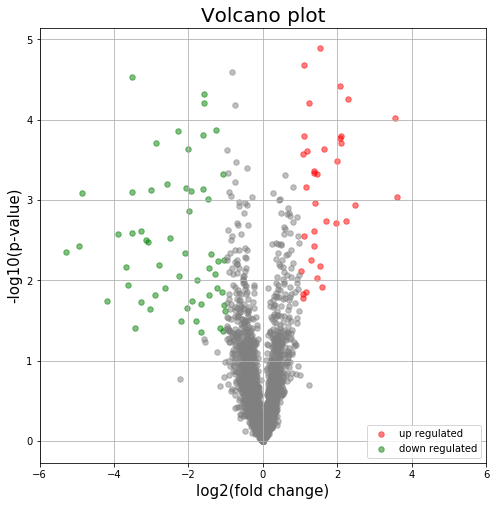

In [12]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel("log2(fold change)", fontsize = 15)
ax.set_ylabel("-log10(p-value)", fontsize = 15)
ax.set_title("Volcano plot", fontsize = 20)
ax.scatter(up_prot_df["log fold change"], up_prot_df["log p-value"],
           s=30, alpha=0.5, c="red", label="up regulated")
ax.scatter(down_prot_df["log fold change"], down_prot_df["log p-value"],
           s=30, alpha=0.5, c="green", label="down regulated")
ax.scatter(other_prot_df["log fold change"], other_prot_df["log p-value"],
           s=30, alpha=0.5, c="gray")
ax.set_xlim(-6,6)
ax.legend(loc="lower right")
ax.grid()

## Avec un peu plus d'interactivité...

On souhaite parfois explorer ce type de représentation et obtenir immédiatement la protéine associé à un point particulier.

La bibliothèque *Bokeh* permet une telle interactivité.

In [13]:
# Bokeh pour les graphiques interactifs
from bokeh.io import output_notebook, show
from bokeh.models import HoverTool
from bokeh.plotting import figure
# https://docs.bokeh.org/en/latest/docs/user_guide/jupyter.html
output_notebook()

Loading BokehJS ...

In [14]:
p = figure(plot_width=600, plot_height=600, x_range=(-6,6), title="Volcano plot")
p.title.text_font_size = "16pt"

p.xaxis.axis_label = "log2(fold change)"
p.xaxis.axis_label_text_font_size = "14pt"
p.xaxis.axis_label_text_font_style = "normal"

p.yaxis.axis_label = "-log10(p-value)"
p.yaxis.axis_label_text_font_size = "14pt"
p.yaxis.axis_label_text_font_style = "normal"

p.circle(x="log fold change", y="log p-value", source=up_prot_df,
        size=10, color="red", alpha=0.5, legend_label="up regulated")

p.circle(x="log fold change", y="log p-value", source=down_prot_df, 
        size=10, color="green", alpha=0.5, legend_label="down regulated")

p.circle(x="log fold change", y="log p-value", source=other_prot_df, 
        size=10, color="gray", alpha=0.5)


p.add_tools(HoverTool())
hover = p.select(dict(type=HoverTool))
hover.tooltips = [("accession", "@{accession}"), 
                  ("fold change", "@{fold change}"), 
                  ("p-value", "@{p-value}")]
hover.mode = 'mouse'

p.legend.location = "bottom_right"
p.legend.click_policy = "hide"

show(p)